## Welcome to your notebook for a Group Challenge.


#### Load the necessary packages

note that this notebook can only run in the local arcgis pro, and is not able to run in the arcgis online because arcgis online does not support arcpy package

In [1]:
from arcgis.gis import GIS
gis = GIS("home")
import os
import glob
import zipfile
import arcpy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
arcpy.env.overwriteOutput = True
arcpy.CheckOutExtension("Spatial")

'CheckedOut'

### Now you are ready to start!

we first extract all the data to the given directory. To make sure the data has no conflict with the previous operations, we delete all the files that already exists in the directory and start a fresh start~

In [4]:
os.chdir(r"E:\umich\checking")

In [5]:
# give a fresh new start by deleting all of the files that already exists in the folder

def delete_files_except(directory, keep_filenames):
    # Ensure that the path is absolute and normalized
    directory = os.path.abspath(directory)

    # Convert keep_filenames to a set for faster membership testing
    keep_filenames_set = set(keep_filenames)

    # Check if it's a directory, just in case
    if not os.path.isdir(directory):
        print(f"The directory {directory} does not exist or is not a directory.")
        return

    # Walk through the directory
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Construct the full path of the file
            file_path = os.path.join(root, file)
            # Check if the file is not in the list of filenames to keep
            if file not in keep_filenames_set:
                try:
                    os.remove(file_path)
                    print(f"Deleted: {file_path}")
                except OSError as e:
                    print(f"Error: {e.strerror}, while trying to delete file {file_path}")

delete_files_except('', ['fl.zip', 'gr.zip'])

#unzip fl.zip using zipfile
with zipfile.ZipFile(r'fl.zip', 'r') as zip_ref:
    zip_ref.extractall()
    
with zipfile.ZipFile(r'gr.zip', 'r') as zip_ref:
    zip_ref.extractall()

Deleted: E:\umich\checking\fl\bg2010.dbf
Deleted: E:\umich\checking\fl\bg2010.prj
Deleted: E:\umich\checking\fl\bg2010.shp
Deleted: E:\umich\checking\fl\bg2010.shx
Deleted: E:\umich\checking\fl\flpeop.dbf
Deleted: E:\umich\checking\fl\flpeop.prj
Deleted: E:\umich\checking\fl\flpeop.shp
Deleted: E:\umich\checking\fl\flpeop.shx
Deleted: E:\umich\checking\fl\foodpts.cpg
Deleted: E:\umich\checking\fl\foodpts.dbf
Deleted: E:\umich\checking\fl\foodpts.prj
Deleted: E:\umich\checking\fl\foodpts.shp
Deleted: E:\umich\checking\fl\foodpts.shp.xml
Deleted: E:\umich\checking\fl\foodpts.shx
Deleted: E:\umich\checking\gr\bg2010.dbf
Deleted: E:\umich\checking\gr\bg2010.prj
Deleted: E:\umich\checking\gr\bg2010.shp
Deleted: E:\umich\checking\gr\bg2010.shx
Deleted: E:\umich\checking\gr\foodpts.cpg
Deleted: E:\umich\checking\gr\foodpts.dbf
Deleted: E:\umich\checking\gr\foodpts.prj
Deleted: E:\umich\checking\gr\foodpts.shp
Deleted: E:\umich\checking\gr\foodpts.shp.xml
Deleted: E:\umich\checking\gr\foodpts.

### We can check the data columns to verify we are working correctly

This is for the shapefile that we need to cluster with

In [6]:
os.chdir('fl')

In [7]:
# List fields using the ListFields function
fields = arcpy.ListFields('foodpts.shp') 

# Iterate through the fields and print their names
for field in fields:
    print(field.name)

FID
Shape
OBJECTID
ORIGINAL_I
COMPANYNAM
ADDRESS
CITY
STATE
ZIPCODE
CENSUSBLOC
CENSUSTRAC
PRIMARYSIC
PRIMARY_DE
SUB_TYPE
LATITUDE
LONGITUDE
FRANCHISED
EBT_SNAP
DATASET
Shape_1
Date_Revie
fas
oth
ram
eth
far
frm
gro
spc
spm


### population filed

In [8]:
# List fields using the ListFields function
fields = arcpy.ListFields('flpeop.shp')

# Iterate through the fields and print their names
for field in fields:
    print(field.name)


FID
Shape
Id


### now we define the radius we are interested in and the columns

you can revise the radius in meters and you can also revise the columns that you are interested in

In [9]:
# you may change the column that you are interested in
search_radii = [805, 1609, 4828, 8047] # in meters
food_outlet_types = ['fas', 'oth', 'ram', 'eth', 
                     'far', 'frm', 'gro', 'spc', 'spm']  # Placeholder types

### Classifying the data by columns

To make sure our data runs correctly and more efficient, we first classify the data by the name and it is good way to check the number of each type of stores in the data to get a clear understanding

In [10]:
shapefile = "foodpts.shp"
output_directory = 'output'  # Define an output directory for the new shapefiles

if not os.path.exists(output_directory):
    os.mkdir(output_directory)

for field_name in food_outlet_types:
    # Make a feature layer from the shapefile
    foodpts = arcpy.MakeFeatureLayer_management(shapefile, "foodpts_Layer")

    # Construct a query that selects only features where the value of the field is equal to 1
    query = f"{field_name} = 1"
    arcpy.SelectLayerByAttribute_management(foodpts, "NEW_SELECTION", query)
    
    # Get the number of selected features
    count_result = arcpy.GetCount_management(foodpts)
    count = int(count_result.getOutput(0))
    print(field_name, "has", count, "features selected.")

    if count > 0:
        # Define the path for the new shapefile
        output_shapefile = os.path.join(output_directory, f"{field_name}.shp")
        
        # Copy the selected features to a new shapefile
        arcpy.CopyFeatures_management(foodpts, output_shapefile)
        print(f"Selected features for {field_name} have been saved to {output_shapefile}")

    # Clean up the foodpts layer before the next iteration to prevent schema lock errors
    arcpy.Delete_management(foodpts) ### now we define the radius we are interested in and the columns

fas has 941 features selected.
Selected features for fas have been saved to output\fas.shp
oth has 281 features selected.
Selected features for oth have been saved to output\oth.shp
ram has 363 features selected.
Selected features for ram have been saved to output\ram.shp
eth has 273 features selected.
Selected features for eth have been saved to output\eth.shp
far has 122 features selected.
Selected features for far have been saved to output\far.shp
frm has 85 features selected.
Selected features for frm have been saved to output\frm.shp
gro has 139 features selected.
Selected features for gro have been saved to output\gro.shp
spc has 27 features selected.
Selected features for spc have been saved to output\spc.shp
spm has 98 features selected.
Selected features for spm have been saved to output\spm.shp


now we construct each bandwidth correspondingly with the separate shape file

In [11]:
input_directory = 'output'
density_directory = 'density_surfaces'

if not os.path.exists(density_directory):
    os.mkdir(density_directory)
    
# Path to the shapefile containing the locations of 1000 people
people_shapefile = "flpeop.shp"

for field_name in food_outlet_types:
    input_shapefile = os.path.join(input_directory, f"{field_name}.shp")
    # Loop through each search radius
    for radius in search_radii:
        # Define the output density surface
        output_surface = os.path.join(density_directory, f"{field_name}_density_{radius}m.tif")
        
        # Run Kernel Density tool
        # we need to set population file as NONE to calculate density based on point count per area unit (already filter the values with only that value)
        # Adding 'area_unit="SQUARE_MILES"' to output densities in square miles
        # Setting 'method="PLANAR"' for planar measurements
        arcpy.sa.KernelDensity(input_shapefile, 
                               population_field="NONE", 
                               cell_size = 100,  # Consider specifying a cell size in meters to control the output resolution
                               search_radius=radius, area_unit_scale_factor="SQUARE_MILES", out_cell_values="DENSITIES", method="PLANAR",
                               in_barriers=None).save(output_surface)
        print(f"Density surface for {field_name} within {radius} meters has been created.")



Density surface for fas within 805 meters has been created.
Density surface for fas within 1609 meters has been created.
Density surface for fas within 4828 meters has been created.
Density surface for fas within 8047 meters has been created.
Density surface for oth within 805 meters has been created.
Density surface for oth within 1609 meters has been created.
Density surface for oth within 4828 meters has been created.
Density surface for oth within 8047 meters has been created.
Density surface for ram within 805 meters has been created.
Density surface for ram within 1609 meters has been created.
Density surface for ram within 4828 meters has been created.
Density surface for ram within 8047 meters has been created.
Density surface for eth within 805 meters has been created.
Density surface for eth within 1609 meters has been created.
Density surface for eth within 4828 meters has been created.
Density surface for eth within 8047 meters has been created.
Density surface for far with

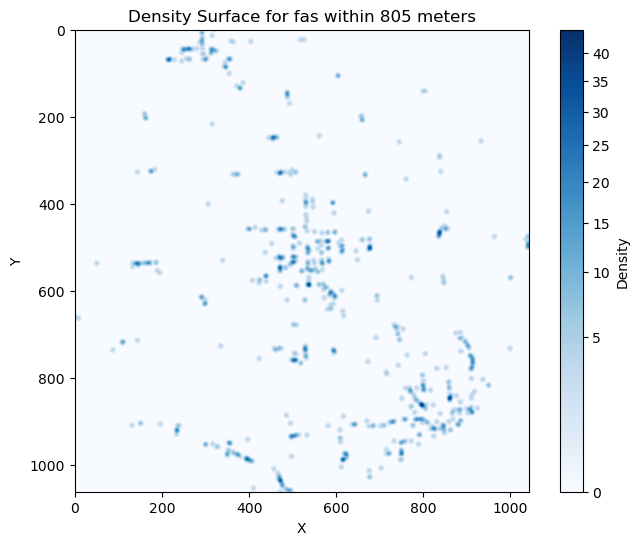

In [12]:
# These codes are for checking if the code is running successfully
cmap = plt.cm.Blues # change the color schema

# define a sample file
radius = 805
field_name = "fas"

# read the file using arcpy.Raster
tif_file = os.path.join(density_directory, f"{field_name}_density_{radius}m.tif")
density_surface = arcpy.Raster(tif_file)
density_array = arcpy.RasterToNumPyArray(density_surface)

# plot the figure to check the result is good or not
plt.figure(figsize=(8, 6))
plt.imshow(density_array, cmap=cmap, norm=colors.PowerNorm(gamma=0.5))
plt.colorbar(label='Density')
plt.title(f"Density Surface for {field_name} within {radius} meters")
plt.xlabel("X")
plt.ylabel("Y")
plt.show() # seems to be good.

In [13]:

# Define the directory to store sampled values
sample_directory = 'sampled_values'

if not os.path.exists(sample_directory):
    os.mkdir(sample_directory)
    
for field_name in food_outlet_types:
    for radius in search_radii:
        # Define the density surface file path
        density_surface_path = os.path.join(density_directory, f"{field_name}_density_{radius}m.tif")
        
        # Define the output table for sampled values
        output_table = os.path.join(sample_directory, f"{field_name}_sampled_{radius}m.dbf")
        
        # Run the Sample tool to intersect the density surface with people locations
        arcpy.sa.Sample(in_rasters=density_surface_path, 
                        in_location_data=people_shapefile, 
                        out_table=output_table, 
                        resampling_type="NEAREST")

        print(f"Sampled values for {field_name} density within {radius} meters have been saved.")

Sampled values for fas density within 805 meters have been saved.
Sampled values for fas density within 1609 meters have been saved.
Sampled values for fas density within 4828 meters have been saved.
Sampled values for fas density within 8047 meters have been saved.
Sampled values for oth density within 805 meters have been saved.
Sampled values for oth density within 1609 meters have been saved.
Sampled values for oth density within 4828 meters have been saved.
Sampled values for oth density within 8047 meters have been saved.
Sampled values for ram density within 805 meters have been saved.
Sampled values for ram density within 1609 meters have been saved.
Sampled values for ram density within 4828 meters have been saved.
Sampled values for ram density within 8047 meters have been saved.
Sampled values for eth density within 805 meters have been saved.
Sampled values for eth density within 1609 meters have been saved.
Sampled values for eth density within 4828 meters have been saved.

## now we can combine the result into one

need to revise the code to generate the unique value

In [14]:
# Initialize a dictionary to map OID to X, Y coordinates
oid_to_xy = {}

# Extract X and Y coordinates for each feature in people_shapefile
with arcpy.da.SearchCursor(people_shapefile, ["OID@", "SHAPE@XY"]) as cursor:
    for row in cursor:
        oid, xy = row
        oid_to_xy[oid] = xy  # Map OID to a tuple of (X, Y)

# Initialize the dictionary to accumulate data
data_dict = {}

for field_name in food_outlet_types:
    for radius in search_radii:
        output_table_path = os.path.join(sample_directory, f"{field_name}_sampled_{radius}m.dbf")
        
        if os.path.exists(output_table_path):
            # Dynamically identify field names
            fields = [f.name for f in arcpy.ListFields(output_table_path)]
            unique_id_field = fields[0]  # Assuming the first field is a unique identifier
            
            # Find the dynamically named value field
            value_field = next((f for f in fields if f.startswith(f'{field_name}_densi')), None)
            
            if value_field:  # Proceed if the value field was found
                with arcpy.da.SearchCursor(output_table_path, [unique_id_field, value_field]) as cursor:
                    for row in cursor:
                        oid, value = row
                        # Retrieve X, Y coordinates for the OID
                        xy = oid_to_xy.get(oid, (None, None))
                        
                        # Initialize or update the dictionary with the value and coordinates
                        if oid not in data_dict:
                            data_dict[oid] = {'OID': oid, 'X': xy[0], 'Y': xy[1]}
                        data_dict[oid][f'{field_name}_{radius}m'] = value

# Convert the dictionary to a pandas DataFrame
data_list = list(data_dict.values())
df = pd.DataFrame(data_list)

# Sort and reset index for clarity
df = df.sort_values('OID').reset_index(drop=True)

print(df.head())

   OID              X              Y  fas_805m  fas_1609m  fas_4828m  \
0    0  710591.880044  264069.898828  0.000000   0.000000   0.000000   
1    1  663260.302036  267085.365833  0.000000   0.231014   0.570214   
2    2  679210.834881  313694.863943  0.000000   0.000000   0.038974   
3    3  691931.155583  313261.296636  0.000000   0.000000   0.009841   
4    4  694004.865003  263312.075135  0.004623   1.695860   1.178510   

   fas_8047m  oth_805m  oth_1609m  oth_4828m  ...  gro_4828m  gro_8047m  \
0   0.082444       0.0   0.000000   0.000000  ...   0.000000   0.011458   
1   0.287656       0.0   0.022866   0.125443  ...   0.153592   0.081833   
2   0.165030       0.0   0.000000   0.006509  ...   0.000486   0.016860   
3   0.056663       0.0   0.000000   0.007853  ...   0.000000   0.000000   
4   0.792867       0.0   0.000000   0.241299  ...   0.000000   0.014032   

   spc_805m  spc_1609m  spc_4828m  spc_8047m  spm_805m  spm_1609m  spm_4828m  \
0       0.0        0.0        0.0   

In [15]:
df.to_csv('result.csv', index = None, encoding = 'utf-8')

## We can also directly generate the result

In [16]:
path_validation = r"E:\umich\checking\output"
if not os.path.exists(path_validation):
    os.mkdir(path_validation)

In [17]:
if not arcpy.Describe(people_shapefile).hasSpatialIndex:
    print("Adding spatial index to the input feature class...")
    arcpy.AddSpatialIndex_management(people_shapefile)
    print("Spatial index added.")


Adding spatial index to the input feature class...
Spatial index added.


In [18]:
# contain all density surfaces in a list
inRasters = []

for field_name in food_outlet_types:
    for radius in search_radii:
        # Define the density surface file path
        density_surface_path = os.path.join(density_directory, f"{field_name}_density_{radius}m.tif")
        
        inRasters.append(density_surface_path)

inRasters

['density_surfaces\\fas_density_805m.tif',
 'density_surfaces\\fas_density_1609m.tif',
 'density_surfaces\\fas_density_4828m.tif',
 'density_surfaces\\fas_density_8047m.tif',
 'density_surfaces\\oth_density_805m.tif',
 'density_surfaces\\oth_density_1609m.tif',
 'density_surfaces\\oth_density_4828m.tif',
 'density_surfaces\\oth_density_8047m.tif',
 'density_surfaces\\ram_density_805m.tif',
 'density_surfaces\\ram_density_1609m.tif',
 'density_surfaces\\ram_density_4828m.tif',
 'density_surfaces\\ram_density_8047m.tif',
 'density_surfaces\\eth_density_805m.tif',
 'density_surfaces\\eth_density_1609m.tif',
 'density_surfaces\\eth_density_4828m.tif',
 'density_surfaces\\eth_density_8047m.tif',
 'density_surfaces\\far_density_805m.tif',
 'density_surfaces\\far_density_1609m.tif',
 'density_surfaces\\far_density_4828m.tif',
 'density_surfaces\\far_density_8047m.tif',
 'density_surfaces\\frm_density_805m.tif',
 'density_surfaces\\frm_density_1609m.tif',
 'density_surfaces\\frm_density_4828m.

In [19]:
arcpy.ia.Sample(
    in_rasters=inRasters,
    in_location_data=people_shapefile,
    out_table=r"E:\umich\checking\output\sample_output.dbf",
    resampling_type="NEAREST",
    unique_id_field="Id",
    process_as_multidimensional="CURRENT_SLICE",
    acquisition_definition=None,
    statistics_type="",
    percentile_value=None,
    buffer_distance=None,
    layout="ROW_WISE",
    generate_feature_class="TABLE"
)

print("Sample processing completed.")

Sample processing completed.
